In [6]:
import numpy as np
import torch
#from env import MultiAgentEnv
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import pandas as pd
import json
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchsampler import ImbalancedDatasetSampler
import random
from collections import deque
from sklearn.decomposition import PCA
#from new_env import New_env
#import gymnasium as gym
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from joblib import dump, load
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
pip install torchsampler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.7 MB/s eta 0:00:00


In [7]:
#TRAIN
X_train = pd.read_csv('/content/drive/MyDrive/HR_Flow/data/X_train.csv')
X_train['employee embedding'] = X_train['employee embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))
X_train['company embedding'] = X_train['company embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))

In [8]:
# Length 38 !!
#Reduce company embeddings to length 6

embeddings_company = np.vstack(X_train['company embedding'].values)


# Création de l'objet PCA pour réduire à 6 dimensions
pca = PCA(n_components=6)

# Fit et transformation des embeddings
reduced_embeddings = pca.fit_transform(embeddings_company)

print(reduced_embeddings.shape)
# Convert embeddings columns in PyTorch tensors
employee_embedding_tensor = torch.tensor(np.vstack(X_train['employee embedding'].values), dtype=torch.float64)
company_embedding_tensor = torch.tensor(reduced_embeddings, dtype=torch.float64)

# Concatenate both
combined_tensor = torch.cat([employee_embedding_tensor, company_embedding_tensor], dim=1)
print("combined tensor shape", combined_tensor.shape)

(29273, 6)
combined tensor shape torch.Size([29273, 38])


In [9]:
#TEST
X_test = pd.read_csv('/content/drive/MyDrive/HR_Flow/data/X_test.csv')
X_test['employee embedding'] = X_test['employee embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))
X_test['company embedding'] = X_test['company embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))

In [22]:
embeddings_company_test = np.vstack(X_test['company embedding'].values)


# Fit et transformation des embeddings
reduced_embeddings_test = pca.transform(embeddings_company_test)

print(reduced_embeddings_test.shape)
# Convert embeddings columns in PyTorch tensors
employee_embedding_tensor_test = torch.tensor(np.vstack(X_test['employee embedding'].values), dtype=torch.float64)
company_embedding_tensor_test = torch.tensor(reduced_embeddings_test, dtype=torch.float64)

# Concatenate both
combined_tensor_test = torch.cat([employee_embedding_tensor_test, company_embedding_tensor_test], dim=1)
print("combined tensor shape", combined_tensor_test.shape)

(7327, 6)
combined tensor shape torch.Size([7327, 38])


In [27]:
#TRAIN
y_train = pd.read_csv('/content/drive/MyDrive/HR_Flow/data/y_train.csv', index_col=0)
encoding_map = {
        "Assistant": 0,
        "Executive": 0,
        "Manager": 1,
        "Director": 1,
    }

y_train = torch.tensor(np.array([encoding_map[category] for category in y_train['position']]))

In [26]:
#TEST

y_test = pd.read_csv('/content/drive/MyDrive/HR_Flow/data/y_test.csv', index_col=0)
encoding_map = {
        "Assistant": 0,
        "Executive": 0,
        "Manager": 1,
        "Director": 1,
    }

y_test = torch.tensor(np.array([encoding_map[category] for category in y_test['position']]))

In [135]:
from sklearn.utils import shuffle
from imblearn.under_sampling import NearMiss
undersample = NearMiss(version=1, n_neighbors=3)
X_undersampled, y_undersampled = undersample.fit_resample(np.array(combined_tensor), np.array(y_train))
X_undersampled, y_undersampled = shuffle(X_undersampled, y_undersampled, random_state=42)

In [138]:
pd.DataFrame(y_undersampled).value_counts()

0    2457
1    2457
dtype: int64

 ## Binary classification preprocessing

## Model Encoder-Decoder NEMO



In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryFocalLoss(nn.Module):
    """
    This is an implementation of Focal Loss for binary classification tasks.

    Parameters:
    - alpha (float): Weighting factor for the positive class. It balances the importance between positive and negative examples.
                     A value of 0.25 is often used.
    - gamma (float): Focusing parameter that adjusts the rate at which easy examples are down-weighted.
                     Values in the range of 2 to 5 are common.
    - reduction (str): Specifies the reduction to apply to the output. 'none' | 'mean' | 'sum'
    """

    def __init__(self, alpha=0.95, gamma=3.0, reduction='mean'):
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Compute the focal loss between `inputs` and the ground truth `targets`.

        inputs: Tensor of arbitrary shape with raw scores (logits) as predicted by the model.
        targets: Tensor of the same shape as input containing binary ground truth labels (0 or 1).
        """
        # Apply the sigmoid to the inputs
        probas = torch.sigmoid(inputs)
        # Calculate the binary cross entropy loss without reduction
        ce_loss = F.binary_cross_entropy(probas, targets, reduction="none")
        # Calculate the focal loss components
        p_t = probas * targets + (1 - probas) * (1 - targets)
        focal_loss = (1 - p_t) ** self.gamma * ce_loss
        if self.alpha >=0:
          alpha_t = self.alpha * targets + (1-self.alpha) * (1- targets)
          focal_loss = alpha_t*focal_loss
        # Apply the specified reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        # Linear layer to adjust embedding dimension if necessary
        self.linear = nn.Linear(input_size, hidden_size)

    def forward(self,embeddings):
        # Assuming embeddings are already in the desired format
        context_vector = torch.tanh(self.linear(embeddings))
        return context_vector

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, num_classes=4):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Use num_classes for both companies and titles if they share the same classes
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, context_vector, hidden=None):
        # LSTM for decoding career path
        output, hidden = self.lstm(context_vector.unsqueeze(1), hidden)
        logits = self.classifier(output.squeeze(1))
        return logits, hidden

class NEMO(nn.Module):
    def __init__(self, input_size=38, hidden_size=64, num_layers=2, num_classes=1):
        super(NEMO, self).__init__()
        self.encoder = Encoder(input_size, hidden_size)
        self.decoder = Decoder(hidden_size, hidden_size, num_layers, num_classes)

    def forward(self, embeddings):
        context_vector = self.encoder(embeddings)
        logits, _ = self.decoder(context_vector)
        return logits


In [71]:
class PreprocessedCareerDataset(Dataset):
    def __init__(self, input_embeddings, target_labels):
        """
        Args:
            input_embeddings (Tensor): Tensors of input embeddings with shape [N, 64],
                                       where N is the number of samples.
            target_labels (Tensor): Tensor of target labels for each sample.
        """
        self.input_embeddings = input_embeddings
        self.target_labels = target_labels

    def __len__(self):
        return len(self.input_embeddings)

    def __getitem__(self, idx):
        return {
            'input_embeddings': self.input_embeddings[idx],
            'target_labels': self.target_labels[idx]
        }
    def get_labels(self):
        return self.target_labels

In [140]:
N = 1000  # Number of samples
embed_dim = 38  # Dimension of the embedding
num_classes = 4  # Example number of classes for the target labels

# Randomly generated embeddings and labels for demonstration
#input_embeddings = torch.randn(N, embed_dim)
#target_labels = torch.randint(0, num_classes, (N,))

# Initialize the dataset
dataset = PreprocessedCareerDataset(X_undersampled, y_undersampled)

# DataLoader
dataloader = DataLoader(dataset, sampler=ImbalancedDatasetSampler(dataset), batch_size=128)



In [98]:
num_epochs=100
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", device)
model = NEMO()
model = model.double()
model.to(device)
pos_weight = torch.tensor([2])  # Set this to a value > 1 to penalize class 1 more
total = 26816 + 2457
weight_for_0 = 1 / (26816 / total)
weight_for_1 = 1 / (2457 / total)

# Or, for a more balanced approach, just use the ratio of instances
# weight_for_0 = 2457 / total
# weight_for_1 = 26816 / total

pos_weight = torch.tensor([weight_for_1 / weight_for_0])

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#sample_weight = torch.tensor([1/10, 1/10, 4/10,4/10])
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
      input_embeddings, target = batch['input_embeddings'], batch['target_labels']
      #print(input_embeddings)
      optimizer.zero_grad()

      title_logits = model(input_embeddings.to(device))

      #loss_company = criterion(company_logits, companies
      #print(title_logits.dtype)
      #print(target.dtype)
      title_logits = title_logits.float()
      target = target.float()
      #print(title_logits.dtype)
      #print(target.dtype)
      loss= criterion(title_logits.squeeze(1), target)
      #loss = (loss * sample_weight).mean()
      # Combine losses

      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      torch.save(model.state_dict(), '/content/drive/MyDrive/HR_Flow/model_simple10epochs.pt')

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")


Using cpu
Epoch 1, Loss: 1.9528343911774815
Epoch 2, Loss: 1.6338422787762106
Epoch 3, Loss: 1.6310821932996724
Epoch 4, Loss: 1.6134104661025335
Epoch 5, Loss: 1.6106270228931476
Epoch 6, Loss: 1.5977849856214232
Epoch 7, Loss: 1.5864218103833594
Epoch 8, Loss: 1.5693165761414574
Epoch 9, Loss: 1.5619024834778632
Epoch 10, Loss: 1.5429622262846434
Epoch 11, Loss: 1.5097502058770458
Epoch 12, Loss: 1.4933882019925846
Epoch 13, Loss: 1.4709718336705038
Epoch 14, Loss: 1.4556476320241736
Epoch 15, Loss: 1.413327850108584
Epoch 16, Loss: 1.3867297469268198
Epoch 17, Loss: 1.360731002024688
Epoch 18, Loss: 1.3287808161115022
Epoch 19, Loss: 1.300790202149137
Epoch 20, Loss: 1.2597771591494697
Epoch 21, Loss: 1.2325285259292635
Epoch 22, Loss: 1.1881930919193284
Epoch 23, Loss: 1.1605273753274477
Epoch 24, Loss: 1.1345343795405725
Epoch 25, Loss: 1.0969370051762943
Epoch 26, Loss: 1.0769267509077314
Epoch 27, Loss: 1.053961344160888
Epoch 28, Loss: 1.0318287644844388
Epoch 29, Loss: 0.99589

In [93]:
pd.DataFrame(predicted_classes).value_counts()

0    29273
dtype: int64

In [96]:
model = NEMO()
model = model.double()
model.load_state_dict(torch.load('/content/drive/MyDrive/HR_Flow/model_simple10epochs.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [97]:
model.eval()
device="cpu"
with torch.no_grad():  # Désactiver le calcul de gradient pour accélérer les calculs et réduire la mémoire
    predictions = model(combined_tensor.to(device))
    predicted_classes = torch.argmax(predictions, dim=1)
    print("Classe prédite:", predicted_classes)
print("accuracy", accuracy_score(np.array(predicted_classes.cpu()), y_train))
print("f1-score", f1_score(np.array(predicted_classes), y_train, average="macro"))

Classe prédite: tensor([0, 0, 0,  ..., 0, 0, 0])
accuracy 0.9160659993850989
f1-score 0.47809730963290487


In [90]:
pd.DataFrame(y_train).value_counts()

0    26816
1     2457
dtype: int64

Text(0.5, 25.722222222222214, 'Predicted label')

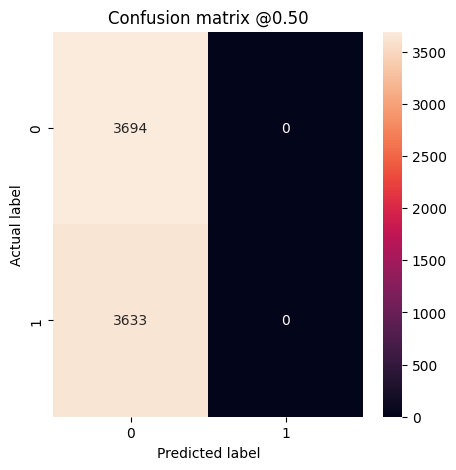

In [78]:
import seaborn as sns
cm = confusion_matrix(y_test, np.array(predicted_classes))
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix @{:.2f}'.format(0.5))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
import seaborn as sns

In [99]:
pip install transformers torch

In [100]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)  # Adjust num_labels as per your task


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class ClassifierBERT(nn.Module):
  def __init__(self,dim_input, hidden_dim, num_classes):
    super(ClassifierBERT, self).__init__()
    self.fc1 = nn.Linear(dim_input, hidden_dim)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_dim, num_classes)

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x


In [104]:
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW
attention_mask = torch.any(combined_tensor != 0, dim=1).int()
# Supposons que `encoded_inputs` et `labels` sont vos données et étiquettes d'entraînement
dataset = TensorDataset(combined_tensor, attention_mask, y_train)
dataloader = DataLoader(dataset, batch_size=8)

# Optimiseur
optimizer = AdamW(model.parameters(), lr=5e-5)

# Boucle d'entraînement simplifiée
model.train()
for batch in dataloader:
    optimizer.zero_grad()
    input_ids, attention_mask, labels = batch
    outputs = model(input_ids.float(), attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

In [105]:
pd.DataFrame(y_train).value_counts()

0    26816
1     2457
dtype: int64

In [141]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerClassifier(nn.Module):
    def __init__(self, input_size=38, num_layers=4, nhead=2, num_classes=1):
        super(TransformerClassifier, self).__init__()
        encoder_layers = TransformerEncoderLayer(d_model=input_size, nhead=nhead)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(38, num_classes)

    def forward(self, x):
        x = self.transformer_encoder(x)
        #x = x.mean(dim=1)
        #print(x.shape)  # Aggregation des sorties
        x = self.decoder(x)
        return x

In [ ]:
num_epochs=50
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", device)
model = TransformerClassifier()
model = model.double()
model.to(device)
pos_weight = torch.tensor([2])  # Set this to a value > 1 to penalize class 1 more
#total = 26816 + 2457
#weight_for_0 = 1 / (26816 / total)
#weight_for_1 = 1 / (2457 / total)

# Or, for a more balanced approach, just use the ratio of instances
# weight_for_0 = 2457 / total
# weight_for_1 = 26816 / total

#pos_weight = torch.tensor([weight_for_1 / weight_for_0])

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#sample_weight = torch.tensor([1/10, 1/10, 4/10,4/10])
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
      input_embeddings, target = batch['input_embeddings'], batch['target_labels']
      #print(input_embeddings)
      optimizer.zero_grad()

      title_logits = model(input_embeddings.to(device))

      #loss_company = criterion(company_logits, companies
      #print(title_logits.dtype)
      #print(target.dtype)
      title_logits = title_logits.float()
      target = target.float()
      #print(title_logits)
      #print(target.shape)

      loss= criterion(title_logits.squeeze(1), target)
      #loss = (loss * sample_weight).mean()
      # Combine losses

      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      torch.save(model.state_dict(), '/content/drive/MyDrive/HR_Flow/model_simple10epochs.pt')

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")

Using cpu


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Loss: 0.7284349799156189
Epoch 2, Loss: 0.693148230895018
Epoch 3, Loss: 0.6705256669949262
Epoch 4, Loss: 0.6240415206322303
Epoch 5, Loss: 0.5869991809893877
Epoch 6, Loss: 0.5698820023964613
Epoch 7, Loss: 0.5291488720820501
Epoch 8, Loss: 0.5176600997264569
Epoch 9, Loss: 0.5097484642114395
Epoch 10, Loss: 0.5056232664829645
Epoch 11, Loss: 0.487852421326515
Epoch 12, Loss: 0.47146941606815046
Epoch 13, Loss: 0.471808461806713
Epoch 14, Loss: 0.47393582188166106
Epoch 15, Loss: 0.44968067529873973
Epoch 16, Loss: 0.45089720227779484
Epoch 17, Loss: 0.42403613527615863
Epoch 18, Loss: 0.4354154551640535
Epoch 19, Loss: 0.4543462296326955
Epoch 20, Loss: 0.4140533269980015
Epoch 21, Loss: 0.41403335409286696
Epoch 22, Loss: 0.39004570169326586
Epoch 23, Loss: 0.3718008261460524
Epoch 24, Loss: 0.36852797407370347
Epoch 25, Loss: 0.3613978395095238
Epoch 26, Loss: 0.3788716632586259
Epoch 27, Loss: 0.34508193494417727
Epoch 28, Loss: 0.34593351873067707
Epoch 29, Loss: 0.3406

In [132]:
model.eval()
device="cpu"
with torch.no_grad():  # Désactiver le calcul de gradient pour accélérer les calculs et réduire la mémoire
    predictions = model(combined_tensor.to(device))
    predicted_classes = torch.argmax(predictions, dim=1)
    print("Classe prédite:", predicted_classes)
print("accuracy", accuracy_score(np.array(predicted_classes.cpu()), y_train))
print("f1-score", f1_score(np.array(predicted_classes), y_train, average="macro"))

Classe prédite: tensor([0, 0, 0,  ..., 0, 0, 0])
accuracy 0.9160659993850989
f1-score 0.47809730963290487
